# Softmax model

From the devlopment and the research required to implement the matrix factorisation algorithims, we notice some limitations: 

1. Only user and artist interactions are used in our matrix factoriation model. The inner product of the subsequent user and artist embeddings may be not enough to capture and represent the complex relations in the user and artists. 

2. The matrix factorisation methods suffer heavily from the cold start problem due to the absense of an embedding for new artists. 

3. When dot product is used as the similarity measure, there is tendency for it to recommend artist with the most amount of interactions, which may fail for users with niche listening habits. 

4. We can not query a user that is not present in the training set.

5. Adding side features is difficult to do in matrix factorisation methods.

Several of these limitations motivate us to develop a non-linear generalization of factorization techniques. We choose a softmax deep learning model as we can easily incorporate query features and item features. This model treats the problem as a multiclass prediction problem in which:

- Input is a query vector
- Ouput is the probability vector with size equal to the number of artists present in the Last.fm dataset. This probability represents the likehood of user to have listened to each artist. 

**Figure 3**: The softmax model
![softmax model](https://github.com/daniel-yj-yang/ml/raw/f4b0b37f89c74e4a68ed764bf9261a8c9d9df338/DNN-softmax/images/DNN-softmax-concepts.png)


## Quick Links
- [Setup](#setup)
- [Softmax Model](#softmax-model)
  - [Define loss function](#define-the-loss-function)
  - [Build Model](#build-a-softmax-model)
  - [Train model](#train-the-softmax-model)
- [Evaulate Embeddings](#evaluate-the-embeddings)
- [Demo](#demo) 

## Setup
The next code cells detail the initial preparatory steps needed for the development of our softmax model, namely importing
the required libraries; scaling the ids of users and artists;finding the most assigned tag of an artist;

In [2]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")



Instructions for updating:
non-resource variables are not supported in the long term
Installing Altair...


In [ ]:
# from google.colab import drive
# !pip install --upgrade -q gspread

# from google.colab import auth
# import gspread
# from oauth2client.client import GoogleCredentials
# drive.mount('/content/drive/')
# os.chdir("/content/drive/My Drive/DCU/fouth_year/advanced_machine_learning/music-recommodation-system")


Mounted at /content/drive/


In [ ]:

def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test


DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores



In [ ]:


artists = pd.read_csv('data/artists.dat', sep='\t')
artist_index = dict(zip(sorted(artists['id'].unique()), [str(num) for num in  range(0,artists['id'].nunique())]))
artists = artists.replace({"id": artist_index})
artists = artists.astype(str)
artists.rename({'id':'artistID'}, inplace=True, axis=1)

user_artists = pd.read_csv('data/user_artists.dat', sep='\t')
user_index = dict(zip(sorted(user_artists['userID'].unique()), [str(num) for num in range(0,user_artists['userID'].nunique())]))
user_artists['weight'] = 1
user_artists = user_artists.replace({"artistID": artist_index,"userID":user_index})
user_artists = user_artists.astype(str)


In [ ]:

user_taggedartists = pd.read_csv(r'data/user_taggedartists-timestamps.dat', sep='\t')
user_taggedartists = user_taggedartists.replace({"artistID": artist_index,"userID":user_index})
user_taggedartists = user_taggedartists.astype(str)
user_taggedartists_years = pd.read_csv(r'data/user_taggedartists.dat', sep='\t')
user_taggedartists_years = user_taggedartists_years.astype(str)

tags = pd.read_csv(open('data/tags.dat', errors='replace'), sep='\t')
tags = tags.astype(str)
user_taggedartists = pd.merge(user_taggedartists, tags, on=['tagID'])


In [ ]:

top_15_tags = user_taggedartists['tagValue'].value_counts().index[0:15]
user_taggedartists['top15TagValue'] = None
for index, row in user_taggedartists.iterrows():
  if row['tagValue'] in top_15_tags:
    user_taggedartists.iloc[index, -1] = row['tagValue']
  
user_taggedartists.fillna('N/A',inplace=True)


In [ ]:
artists = pd.merge(user_taggedartists, artists, on=['artistID'], how='right')[['artistID','name','top15TagValue','tagValue']].fillna('N/A')
artists.groupby(['artistID','name','top15TagValue']).agg(lambda x:x.value_counts().index[0]).reset_index()
artists = artists.drop_duplicates(subset=['artistID'])
artists.rename({'tagValue':'mostCommonGenre'},axis=1, inplace=True)




/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Softmax Model

Our softmax model predicts whether a user has listened to a particular artist or not. The model will take as input a feature vector $x$ representing the list of artists the user has rated i.e. `rated_artists`. The `make_batch()` function generates a batch where each batch contains the following variables
- ArtistID: A tensor of strings of the artist ids that the user rated.
- tag: A tensor of strings of the tags of those artists
- year: A tensor of strings of the years where a user has annoted an artist with a tag. This was an attempt to model
the relevance of an artist during a particular time-frame


The next code cells detail the pre-processings required to create two dictionaries (`year_dict` and `tags_dict`) which hold the data required to implement the tag and year batch features. 

In [ ]:

user_taggedartists_years_unique = user_taggedartists_years.drop_duplicates(subset=['artistID','year'])[['artistID','year']]
user_taggedartists_years_unique = user_taggedartists_years_unique.groupby('artistID')['year'].apply(list).reset_index()
years_dict = dict(zip(user_taggedartists_years_unique['artistID'], user_taggedartists_years_unique['year']))
unknown_years = set(artists['artistID'].values).difference(set(years_dict.keys()))
for  unknown_year in unknown_years:
  years_dict[unknown_year] = []

In [ ]:

user_taggedartists_tags = user_taggedartists.drop_duplicates(subset=['artistID','tagValue'])[['artistID','tagValue']]
user_taggedartists_tags = user_taggedartists_tags.groupby('artistID')['tagValue'].apply(list).reset_index()
tags_dict = dict(zip(user_taggedartists_tags['artistID'], user_taggedartists_tags['tagValue']))
unkown_tags = set(artists['artistID'].values).difference(set(tags_dict.keys()))
for  unknown_tag in unkown_tags:
  tags_dict[unknown_tag] = []

In [ ]:
rated_artists = (user_artists[["userID", "artistID"]]
                .groupby("userID", as_index=False)
                .aggregate(lambda x: list(x)))

In [ ]:

def make_batch(ratings, batch_size):
  """Creates a batch of examples.
  Args:
    ratings: A DataFrame of ratings such that examples["artistID"] is a list of
      artists rated by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  artist = []
  year = []
  tag = []
  label = []
  for movie_ids in ratings["artistID"].values:
    artist.append(movie_ids)
    tag.append([str(x) for movie_id in movie_ids for x in tags_dict[movie_id]])
    year.append([str(x) for movie_id in movie_ids for x in years_dict[movie_id]])
    label.append([int(movie_id) for movie_id in movie_ids])

  features = {
      "artistID": pad(artist, ""),
      "year": pad(year, ""),
      "tag": pad(tag, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))



### Define the loss function

As is illustrated in the Figure 3, the softmax model maps the input features $x$ to a user embedding $\psi(x) \in \mathbb R^d$, where $d$ is the embedding dimension. We then mutiply this vector by a artist embedding matrix $V \in \mathbb R^{n \times d}$ (where $n$ is the number of artists). The final output is the softmax of this product. 

$$
\hat p(x) = \text{softmax}(\psi(x) V^\top).
$$

Similar to our matrix factorisation approach, we one-hot encode the user-artist interactions ($p$). These represent the ground truth i.e. $p = 1$. The loss between the model produced propaility and the target label is the cross-entropy between $\hat p(x)$ and $p$. The loss function  compares two probability vectors (the ground truth and the output of the model).



In [ ]:
def softmax_loss(user_embeddings, artist_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    artist_embeddings: A tensor of shape [num_artists, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  movie_emb_dim = artist_embeddings.shape[1].value
  if user_emb_dim != movie_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the movie embedding "
        "dimension % d" % (user_emb_dim, movie_emb_dim))

  logits = tf.matmul(user_embeddings, artist_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss


### Build a softmax model

We  now build a softmax model using the `build_softmax_model()` function and `train_softmax_model` class. The `build_softmax_model` function concatenates the input emeddings (artistID, tag and year) to form the input layer. We choose 35 hidden layers in our softmax model. By adding hidden layers and non-linear activation functions, we hope that the model can capture more complex relationships in the last.fm data. The last hidden layer in the model is then  multiplied by the artist embeddings to obtain the logits layer. For the target label, we will use a randomly-sampled artistID from the list of artist the user rated.


In [ ]:
class train_softmax_model(object):
  """Simple class that represents a trains the softmax model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a Matrix normalisation model 
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None


  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings


  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to SDG
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [ ]:


def build_softmax_model(rated_artists, embedding_cols, hidden_dims):
  """Builds a Softmax model for Last.fm.
  Args:
    rated_artists: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A train_softmax_model object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_artists, test_rated_artists = split_dataframe(rated_artists)
  train_batch = make_batch(train_rated_artists, 200)
  test_batch = make_batch(test_rated_artists, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    artist_embeddings = tf.get_variable(
        "input_layer/artistID_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, artist_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, artist_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, artist_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"artistID": artist_embeddings}
  return train_softmax_model(embeddings, train_loss, metrics)



### Train the Softmax model

We now  train the softmax model. There are four hyper-parameters that we can tune, namely
- learning rate
- number of iterations
- input embedding dimensions (the `input_dims` argument)
- number of hidden layers and size of each layer (the `hidden_dims` argument)


 iteration 3000: train_loss=6.705453, test_loss=7.169943, test_precision_at_10=0.008087

({'test_loss': 7.169943, 'train_loss': 6.705453},
 {'test_precision_at_10': 0.008086637787404198})

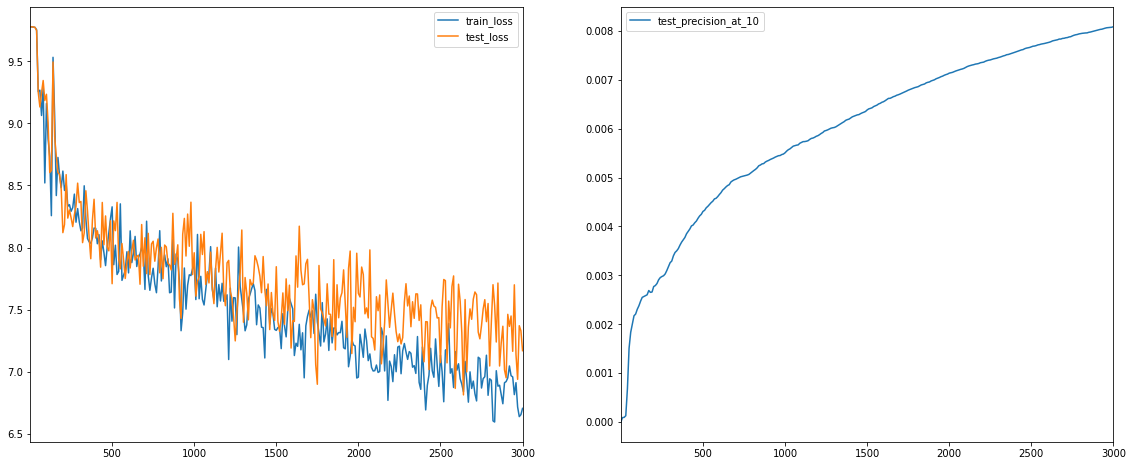

In [ ]:

# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  if key == 'artistID':
    unique_keys = artists['artistID'].values
  elif key == 'tag':
    unique_keys = user_taggedartists['tagValue'].values
  elif key =='year':
    unique_keys = user_taggedartists_years['year'].values

  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(unique_keys)), num_oov_buckets=0)

  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      combiner='mean')

with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      rated_artists,
      embedding_cols=[
          make_embedding_col("artistID", 35),
          make_embedding_col("tag", 3),
          make_embedding_col("year", 2),
      ],
      hidden_dims=[35])

softmax_model.train(
    learning_rate=8., num_iterations=3000, optimizer=tf.train.AdagradOptimizer)



Compared to the matrix factorisation methods, we observe a more ragged decrease in the softmax loss function as the
model progresses compared to the MSE of the matrix factorisation methods.



### Evaluate the embeddings
Like the previous section, we evaluate the artist embeddings. We use the same similarity measures as before, to inspect
the robustness of the softmax model.

In [ ]:
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for artist ids that match the given substring.
  ids =  artists[artists['name'].str.contains(title_substring)].artistID.values
  titles = artists[artists.artistID.isin(ids)]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artists with name %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  scores = compute_scores(
      model.embeddings["artistID"][int(ids)], model.embeddings["artistID"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'name': artists.sort_values('artistID', ascending=True)['name'],
      'most assigned tag':artists.sort_values('artistID', ascending=True)['mostCommonGenre']
  })
  return df.sort_values([score_key], ascending=False).head(k)

In [ ]:
artist_neighbors(softmax_model, "The Cure", DOT)

Nearest neighbors of : The Cure.


dot score                 name most assigned tag
161729  32.578003              Firebug               ska
62469   31.128336              Erasure        electronic
161803  30.389132  Peter Pan Speedrock         rock hard
161906  29.331894          Torment Day        electronic
161368  29.005989    Perrey & Kingsley               N/A
161913  28.973671               Пурген              punk

In [ ]:
artist_neighbors(softmax_model, "The Cure", COSINE)

Nearest neighbors of : The Cure.


cosine score               name          most assigned tag
161729      1.000000            Firebug                        ska
162859      0.920241     Taylor Lautner                        N/A
165317      0.895609               Rojo                        N/A
161368      0.880020  Perrey & Kingsley                        N/A
395         0.872602           Behemoth                death metal
164005      0.861260      Chris Crocker  very very guilty pleasure

We believe that matrix factorisation models’ embeddings actually produce better results than the softmax model. These
artists have little in common to The Cure. We hypothesis that adding user-submitted tags may cause the model to learn
random noise since users are not domain experts. There may be noise or “contradictions” within the tag data. DNNs
also require more data in general, when compared to traditional machine learning methods such as weighted matrix
factorisation. The limited user-artist interaction supply (1892 instances in the rated_artists df) may not be enough.

In [ ]:
rated_artists.head(5)

userID                                           artistID
0      0  [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 5...
1      1  [95, 96, 97, 98, 99, 100, 101, 102, 103, 104, ...
2     10  [66, 183, 185, 224, 282, 294, 327, 338, 371, 3...
3    100  [597, 610, 735, 739, 744, 746, 747, 763, 769, ...
4   1000  [49, 50, 58, 59, 61, 65, 83, 251, 282, 283, 28...

In [ ]:
def visualize_movie_embeddings(data, x, y):
  genre_filter = alt.selection_multi(fields=['top15TagValue'])
  genre_chart = alt.Chart().mark_bar().encode(
      x="count()",
      y=alt.Y('top15TagValue'),
      color=alt.condition(
          genre_filter,
          alt.Color("top15tagValue:N"),
          alt.value('lightgray'))
  ).properties(height=300, selection=genre_filter)
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "top15TagValue", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'name', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["artistID"])
  artists.loc[:,'x'] = V_proj[:, 0]
  artists.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(artists, 'x', 'y')
tsne_movie_embeddings(softmax_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17632 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


[t-SNE] Computed neighbors for 17632 samples in 5.323s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17632
[t-SNE] Computed conditional probabilities for sample 2000 / 17632
[t-SNE] Computed conditional probabilities for sample 3000 / 17632
[t-SNE] Computed conditional probabilities for sample 4000 / 17632
[t-SNE] Computed conditional probabilities for sample 5000 / 17632
[t-SNE] Computed conditional probabilities for sample 6000 / 17632
[t-SNE] Computed conditional probabilities for sample 7000 / 17632
[t-SNE] Computed conditional probabilities for sample 8000 / 17632
[t-SNE] Computed conditional probabilities for sample 9000 / 17632
[t-SNE] Computed conditional probabilities for sample 10000 / 17632
[t-SNE] Computed conditional probabilities for sample 11000 / 17632
[t-SNE] Computed conditional probabilities for sample 12000 / 17632
[t-SNE] Computed conditional probabilities for sample 13000 / 17632
[t-SNE] Computed conditional probabilities for sample 14000 / 17632

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.800423
[t-SNE] KL divergence after 400 iterations: 3.479889


alt.HConcatChart(...)

In [ ]:

def artist_embedding_norm(models):
  """Visualizes the norm and number of ratings of the artist embeddings.
  Args:
    model: A train_matrix_norm object.
  """
  if not isinstance(models, list):
    models = [models]
    df = pd.DataFrame({
          'name': artists.sort_values('artistID', ascending=True)['name'].values,
        'number of user-artist interactions': user_artists[['artistID','userID']].sort_values('artistID', ascending=True).groupby('artistID').count()['userID'].values,
    })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["artistID"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='number of user-artist interactions',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='number of user-artist interactions', y=norm_key,
        text=alt.condition(nearest, 'name', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

artist_embedding_norm(softmax_model)

alt.HConcatChart(...)

Additionally, when the artist embeddings are visualised they do not demonstrate much clustering when we color-code the
data points with the corresponding top 15 tag. This is in stark-contrast unlike the matrix factorisation methods. The norm
of the embeddings does not also correlate with the popularity of an artist.


## Demo
You can find the most similar artist to a specified artist using the `artist_neighbours()` function.

In [ ]:
artist_neighbors(softmax_model, 'The Cure', COSINE)

Nearest neighbors of : The Cure.


cosine score               name          most assigned tag
161729      1.000000            Firebug                        ska
162859      0.920241     Taylor Lautner                        N/A
165317      0.895609               Rojo                        N/A
161368      0.880020  Perrey & Kingsley                        N/A
395         0.872602           Behemoth                death metal
164005      0.861260      Chris Crocker  very very guilty pleasure

Overall, our softmax model generates poor recommendations. We tried experimenting with different learning rates and
hidden layers but we did not observe any increased performance. An inital comparison of this model with the proposed
baseline (*detailed later on*), showcased the failures of this model. Therefore, we decide not to proceed with evaluating
this model with the other models already specified in this report